# Programming Assignment 2: Classification

### Instructor: Yuanyuan Shi

### Teaching Assistants

- Yuexin Bian, [yubian@ucsd.edu]
- Tz-Ying Wu, [tzw001@ucsd.edu]

## Instructions
1. This assignment must be completed individually.  
2. All solutions should be written in this notebook, you can use markdown cell if you are going to add solutions with regard to discussion or analysis
3. This notebook contains skeleton code, which should not be modified
4. You must run all cells in this notebook and then export it as a pdf. You must also submit this notebook as an .ipynb file.
5. You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.



# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver
import cv2
from glob import glob
np.random.seed(0)
# Comment it if you are not using mac
%config InlineBackend.figure_format = 'retina'

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# use thie plot function to plot the training loss and test loss
def plot(train_loss, test_loss):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.plot(train_loss, label='train_loss')
    ax.plot(test_loss, label='test_loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iterations')
    ax.legend()
    plt.show()

X_train.shape: (3150, 1024), y_train.shape: (3150, 1)
X_test.shape: (1350, 1024), y_test.shape: (1350, 1)


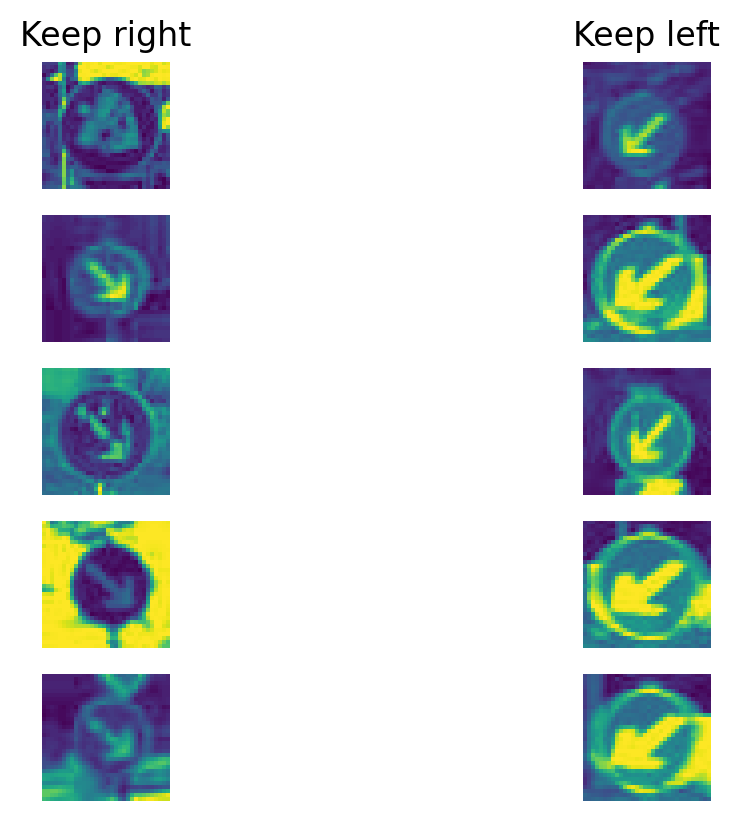

In [2]:
# Load Data for binary classification
left_data_files = glob('data/39/*.jpg')
left_data = np.array([cv2.imread(f,cv2.IMREAD_GRAYSCALE).reshape(-1) for f in left_data_files])
right_data_files = glob('data/38/*.jpg')
right_data = np.array([cv2.imread(f,cv2.IMREAD_GRAYSCALE).reshape(-1) for f in right_data_files])
X_data = np.concatenate((left_data, right_data), axis=0)
y_data = np.concatenate((np.ones((len(left_data),1)),np.zeros((len(right_data),1))), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=40)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

classes = ['Keep right', 'Keep left']
num_classes = 2
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(32, 32))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

## Part1. Binary Classification with Regression  (20 points)
### In this part you will implement 
### 1. Linear regression model (10 points) 
### 2. Report MSE and accuracy for the train set and test set (5 points)
### 3. discuss why linear regression be a poor idea for classification (5 points)
### You are expected to achieve above 47% accuracy for the best set of parameters

In [3]:
#TODO: implement linear regression with L2 regularization model
class LinearRegression():
    """
    Linear regression model: the learnable weight is vector $w$ 
    """
    def __init__(self, d, reg):
        """
        Args:
            d: int, dimension of the data
            reg: float, Scalar giving L2 regularization strength.
        """
        self.reg = reg
        self.d = d
        # TODO: initialize the weight vector and w0 --> self.w, self.w0
        # self.w should be initialized from a Gaussian G(0,1)
        # self.w0 should be initialized to be 0
        self.w = np.random.normal(size=(d,1))
        self.w0 = 0

    
    # TODO: Using the gradient descent to update self.w and self.w0
    def fit(self, X, y):
        """
        Args:
            X: array (N, d) N is the number of data, d is the number of dimension
            y: array (N, 1)
        No return, just update self.w and self.w0
        """
        N, d = X.shape
        assert d == self.d
        self.w = np.linalg.inv(np.dot(X.T,X)+self.reg * np.eye(d))
        self.w = np.dot(np.dot(self.w, X.T), y)
        assert self.w.shape == (d, 1)
        self.w0 = np.average(y)
    
    #TODO: compute the predicted y given X
    def predict(self, X):
        """
        Args:
            X: array (N, d) N is the number of data, d is the number of dimension
        Returns:
            y: array (N, 1)
        """
        N, d = X.shape
        assert d == self.d
        return np.dot(X, self.w)+self.w0



    #TODO: compute mean squared loss given y_true and y_pred
    def evaluate_loss(self, y_true,  y_pred):
        """
        Args:
            y_true: array (N,1) N is the number of labels
            y_pred: array (N,1) N is the number of labels
        Return:
            loss: float, the MSEloss
        """
        assert y_true.shape == y_pred.shape
        return np.average((y_true-y_pred)**2)

    
    #TODO: compute accuracy given given y_true and y_pred
    # First you should process pred_y to be 0 or 1 given the threshold
    # then compute the accuracy
    def evaluate_acc(self, y_true, y_pred, threshold):
        """
        Args:
            y_true: array (N,1) N is the number of labels
            y_pred: array (N,1) N is the number of labels
            threshold: float, 
        Return:
            accuracy: float, the accuracy
        """
        y_pred01 = np.where(y_pred > threshold, 1, 0)
        N = y_true.shape[0]
        correct = 0
        for i in range(N):
            if y_pred01[i,0] == y_true[i,0]:
                correct += 1
        return correct / N       


In [4]:
#TODO: conduct experiments
reg = 0.0 # TODO: choose the appropriate regularization term
N, d = X_train.shape
lr = LinearRegression(d=d, reg=reg)
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
train_mse = lr.evaluate_loss(y_train, y_pred_train)
#TODO: choose the appropriate threshold term
threshold = 0.5
train_acc = lr.evaluate_acc(y_train, y_pred_train, threshold=threshold) 
y_pred_test = lr.predict(X_test)
test_mse = lr.evaluate_loss(y_test, y_pred_test)
test_acc = lr.evaluate_acc(y_test, y_pred_test, threshold=threshold) 
print(f'Train mse: {train_mse}, Train accuracy: {train_acc}')
print(f'Test mse: {test_mse}, Test accuracy: {test_acc}')

Train mse: 13922311977.97629, Train accuracy: 0.33746031746031746
Test mse: 13611761162.55315, Test accuracy: 0.3237037037037037


## Part2. Binary Classification with Logistic Regression (20 points)
### In this part you will implement 
### 1. Logistic regression model (10 points)
### 2. plot log loss vs. iterations for the train set and test set (5 points)
### 3. report the log loss and accuracy (5 points)
### You are expected to achieve above 90% accuracy 

In [5]:
#TODO: implement LogisticRegression with L2 regularization model

def mysigmoid(x):
    return 1 / (1 + np.exp(-x))

def mylog(x):
    return np.log(np.maximum(x, 1e-100))
#because of accuracy of float, sometimes x exactly = 0.0 or 1.0

class LogisticRegression(LinearRegression):
    def __init__(self, d, lr, reg, maxite=100):
        """
        Args:
            d: int, the number of dimension
            maxite: int, the maximum iterations during training to find optimal weights
            lr: float, learning rate
            reg: float, L2 regularization term
        """
        self.d = d
        self.maxite = maxite 
        self.lr = lr
        self.reg = reg
        #TODO: initialize the weight vector and w0--> self.w, self.w0
        # self.w should be initialized from a Gaussian G(0,1), self.w0 should be initialized to be zero
        self.w = np.random.normal(size=(d,1))
        self.w0 = 0
    
    
    # TODO: for every epoch,
    # update the weight vector and w0 (!!!) only using the training data
    # record the log loss for train data and test data
    def train(self, X_train, y_train, X_test, y_test):
        """
        Args:
            X_train: array (N, d) training data
            y_train: array (N, 1) training labels
            X_train: array (N, d) training data
            y_train: array (N, 1) training labels
        Returns:
            train_loss: array (maxite, 1) log loss of maxite iterations
            test_loss: array (maxite, 1) log loss of maxite iterations
        """
        train_losses = []
        test_losses = []
        for i in range(self.maxite):
            wx = np.dot(X_train, self.w) + self.w0
            y = mysigmoid(wx)
            dwx = y - y_train#(N,1)
            dx = np.sum(X_train * dwx, axis=0).reshape(-1,1)#(d,1)
            self.w -= self.lr * (dx + self.reg * self.w)
            self.w0 -= self.lr * (np.sum(dwx) + self.reg * self.w0)
            
            wx = np.dot(X_train, self.w) + self.w0
            yhat_train = mysigmoid(wx)
            train_loss = -np.sum(mylog(yhat_train[y_train==1])) - np.sum(mylog(1-yhat_train[y_train==0]))
            train_losses.append(train_loss)
            yhat_test = mysigmoid(np.dot(X_test, self.w) - self.w0)
            test_loss = -np.sum(mylog(yhat_test[y_test==1])) - np.sum(mylog(1-yhat_test[y_test==0]))
            test_losses.append(test_loss)
        return np.array(train_losses).reshape(-1,1), np.array(test_losses).reshape(-1,1)
    
    #TODO: compute the prediction given X following the assignment equation
    def predict(self, X):
        """
        Args:
            X: array (N, d) N is the number of data, d is the number of dimension
        Returns:
            y: array (N, 1)
        """
        wx = np.dot(X, self.w) + self.w0
        return mysigmoid(wx)
        #return np.where(wx > 0.5, 1, 0)

    
    #TODO: compute log loss given y_true and y_pred
    def evaluate_loss(self, y_true,  y_pred):
        """
        Args:
            y_true: array (N,1) N is the number of labels
            y_pred: array (N,1) N is the number of labels
        Return:
            loss: float, the log loss
        """
        assert y_true.shape == y_pred.shape
        return -np.sum(mylog(y_pred[y_true==1])) - np.sum(mylog(y_pred[y_true==0]))


C:\Users\think\AppData\Local\Temp\ipykernel_21640\3414921613.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


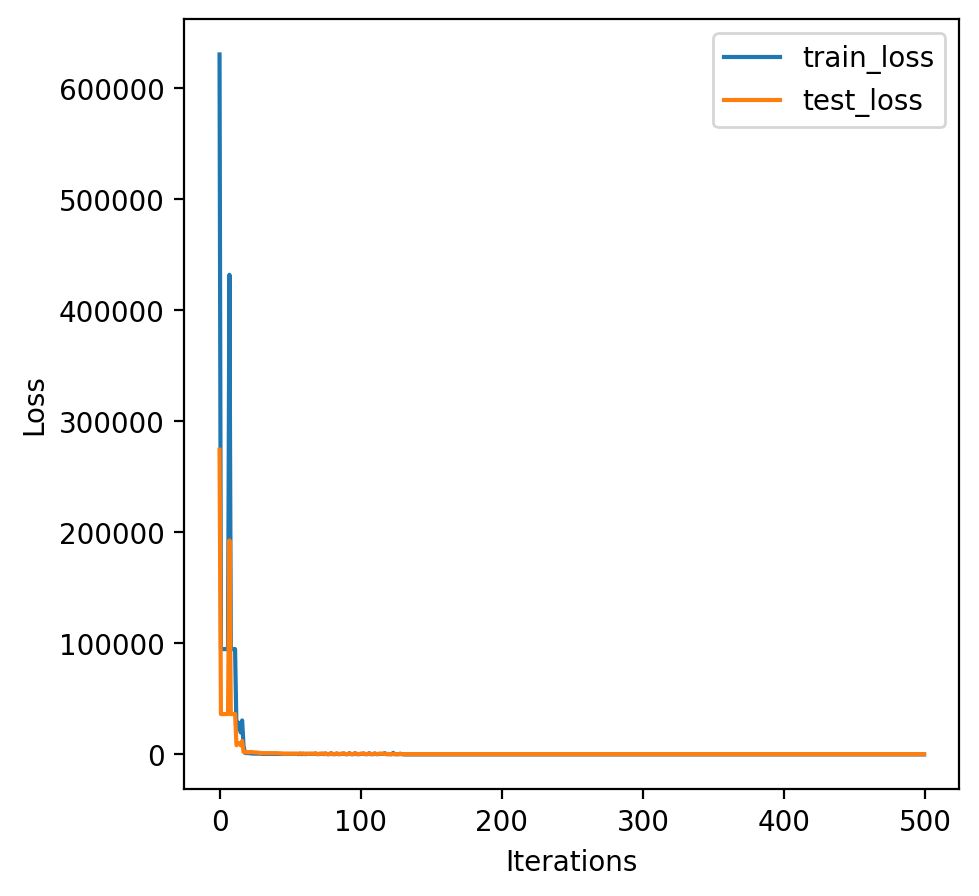

Train loss: 630447.7984617697, Train accuracy: 1.0
Test loss: 274698.4015941897, Test accuracy: 0.9992592592592593


In [6]:
#TODO: conduct experiments
# You are free to change the learning_rate, max_iteration, regularization term parameters
N, d = X_train.shape
Logmodel = LogisticRegression(lr = 0.0001, maxite=500, reg = 1.0, d = d)
train_loss, test_loss = Logmodel.train(X_train, y_train, X_test, y_test)
plot(train_loss, test_loss)

y_pred_train = Logmodel.predict(X_train)
train_loss = Logmodel.evaluate_loss(y_train, y_pred_train)
threshold = 0.5
train_acc = Logmodel.evaluate_acc(y_train, y_pred_train, threshold=threshold) 
y_pred_test = Logmodel.predict(X_test)
test_loss = Logmodel.evaluate_loss(y_test, y_pred_test)
test_acc = Logmodel.evaluate_acc(y_test, y_pred_test, threshold=threshold) 
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')


C:\Users\think\AppData\Local\Temp\ipykernel_21640\3414921613.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[36380.84446931]
[230.2585093]
[230.2585093]
[230.2585093]
best learning rate is  0.01


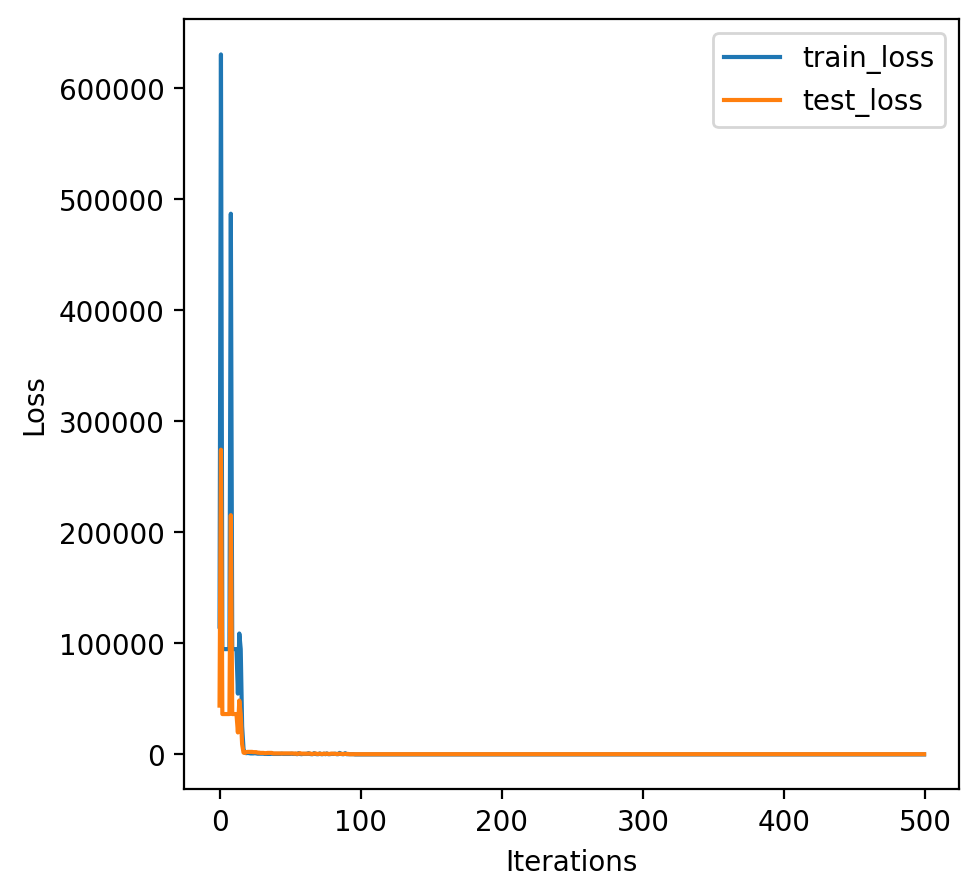

In [7]:
#this block is changing learning rate
best_test_loss = 100000000.0
best_lr = 1.0
best_train_plot = None
best_test_plot = None
for mylr in [0.1, 0.01, 0.001, 0.0001]:
    Logmodel = LogisticRegression(lr = mylr, maxite=500, reg = 1.0, d = d)
    train_loss, test_loss = Logmodel.train(X_train, y_train, X_test, y_test)
    print(test_loss[-1])
    if test_loss[-1] < best_test_loss:
        best_lr = mylr
        best_test_loss = test_loss[-1]
        best_train_plot, best_test_plot = train_loss, test_loss
print("best learning rate is ", best_lr)
plot(best_train_plot, best_test_plot)

## Part4. Softmax classification with MLP (35 points)
### In this part you will implement 
### 1. Affine forward and backward function (4 points)
### 2. ReLU activation function and relu backward pass (4 points)
### 3. Softmax loss layer (4 points)
### 4. build a twolayer neural networks (8 points)
### Conduct experiments using two layer NNs (15 points)
### You are expected to achieve 55% accuracy

## Load data for softmax classification

The number of samples for different categories: 
K_0: 840, K_1: 1470, K_2: 450, K_3: 1288, K_4: 780, K_5: 2280, K_6: 720, K_7: 390, K_8: 3930, K_9: 570
X_train.shape: (8902, 1024), y_train.shape: (8902, 1)
X_test.shape: (3816, 1024), y_test.shape: (3816, 1)


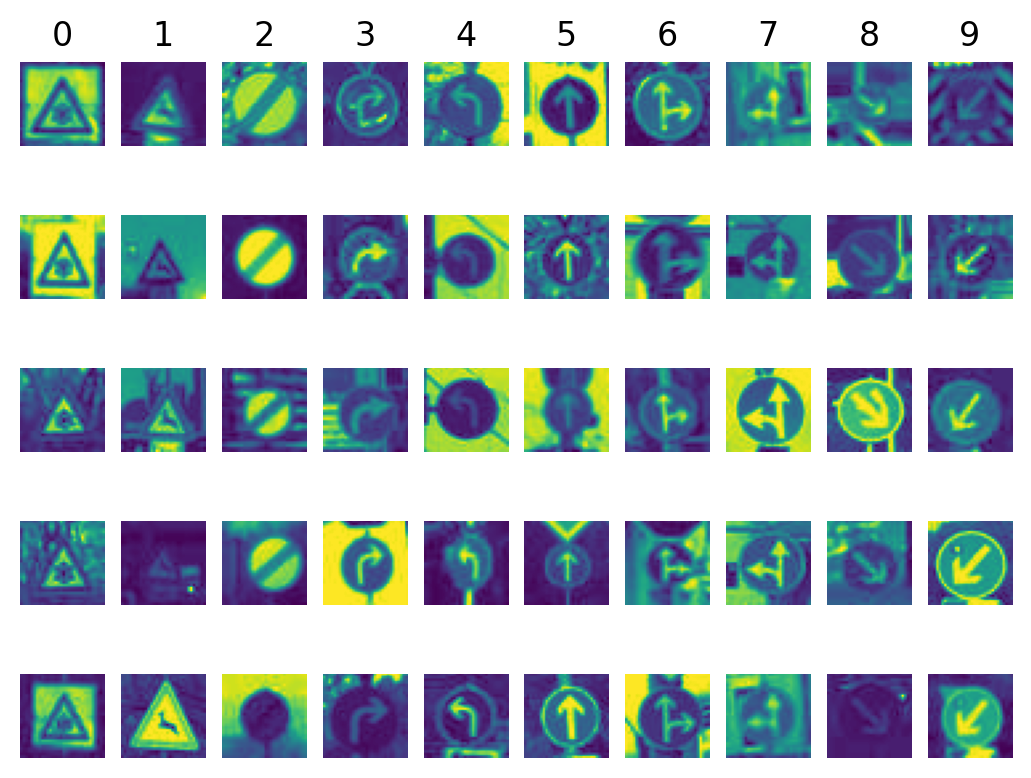

In [8]:
# Load Data for softmax classification
K = 10
class_idx = list(range(30,40)) # the categories to predict
data_files = [glob(f'data/{i}/*.jpg') for i in class_idx]
print('The number of samples for different categories: ')
for i in range(K):
    if i < K-1:
        print(f'K_{i}: {len(data_files[i])}', end=', ')
    else: print(f'K_{i}: {len(data_files[i])}')

number_of_data = [len(data_files[i]) for i in range(K)]
y_data = np.repeat(np.arange(0, K), np.array(number_of_data)).reshape(-1, 1)
X_data_tuple = []
for k in range(K):
    X_data_tuple.append(np.array([cv2.imread(f,cv2.IMREAD_GRAYSCALE).reshape(-1)/255.0 for f in data_files[k]]))
X_data = np.concatenate(X_data_tuple, axis=0)


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=40)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')


classes = ['Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left']
num_classes = K
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(32, 32))
        plt.axis('off')
        if i == 0:
            plt.title(y)

<font size='4' color='orange'>**Task 3.1: Affine layer: foward pass (no for loops are allowed) (1 points).**

In [9]:
#TODO: affine layer: no for loops are allowed
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    N = x.shape[0]
    #x = x.reshape(N, -1)#(N,D)
    out = np.dot(x.reshape(N, -1), w)+b.reshape((1,-1))#(N,M)
    M = w.shape[1]
    assert out.shape == (N, M)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

In [10]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


<font size='4' color='orange'>**Task 3.1: Affine layer: backward pass (no for loops are allowed) (3 points).**
    
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [11]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    N, M = dout.shape
    D = w.shape[0]
    dx = np.dot(dout, w.T).reshape(x.shape)
    dw = np.dot(x.reshape(N, -1).T, dout)
    db = np.sum(dout, axis=0)
    assert dw.shape == (D,M)
    assert db.shape == (M,)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [12]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


<font size='4' color='orange'>**Task 3.2: ReLU activation: forward pass (no for loops are allowed)**
    
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [13]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    
    out = np.maximum(x, 0)
    assert out.shape == x.shape
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

In [14]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


<font size='4' color='orange'>**Task 3.2: ReLU activation: backward pass (no for loops are allowed).**
    
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [15]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    dx = dout.copy()
    dx[x<=0.0] = 0.0
    assert dx.shape == x.shape
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

In [16]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


<font size='4' color='orange'>**Task 3.3: Softmax loss layer (no for loops are allowed) (4 points).**

In [17]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score (probability) for the jth
      class for the ith input before softmax operation.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    ###########################################################################
    # TODO: Implement the softmax_loss function,                              #
    # including the forward and backward passes.                              #
    ###########################################################################
    y = y.flatten()#sometimes type is (N,1) and sometimes (N,)!!! I don't know why
    N, C = x.shape
    scores = x - np.max(x, axis=1, keepdims=True)
    scores = np.exp(x)
    softmax_matrix = scores / np.sum(scores, axis=1, keepdims=True)
    assert scores.shape == x.shape == softmax_matrix.shape == (N,C)
    #loss = np.array([x[i, y[i]] for i in range(N)])
    ind = list(range(N))#avoid using for
    loss = softmax_matrix[ind, y[ind]]#(N,)
    assert loss.shape == (N,)
    loss = -mylog(loss)
    loss = np.average(loss)
    dx = softmax_matrix.copy()
    dx[ind, y[ind]] -= 1.0
    dx /= N

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return loss, dx

In [18]:
# Let's check your implementation
np.random.seed(5330)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302800487936905
dx error:  9.33736593344278e-09


<font size='4' color='orange'>**Task 3.4: Two-layer network (no for loops are allowed in your implementation)**
    
<font size='4'>Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [19]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1.0, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        
        self.params["W1"] = np.random.normal(size=(input_dim, hidden_dim), scale=weight_scale)
        self.params["b1"] = np.zeros((hidden_dim, 1))
        self.params["W2"] = np.random.normal(size=(hidden_dim, num_classes), scale=weight_scale)
        self.params["b2"] = np.zeros((num_classes, 1))
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].
        
        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        
        scores, cache1 = affine_forward(X, self.params["W1"], self.params["b1"])
        #print(scores.shape)#(8904,1024)
        scores, cache_relu1 = relu_forward(scores)
        scores, cache2 = affine_forward(scores, self.params["W2"], self.params["b2"])
        scores, cache_relu2 = relu_forward(scores)        


        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        loss, dx = softmax_loss(scores, y)
        loss += 0.5 * self.reg * (np.sum(self.params["W2"] ** 2)+np.sum(self.params["W1"] ** 2))
        dx = relu_backward(dx, cache_relu2)
        dx, dw2, db2 = affine_backward(dx, cache2)
        grads["W2"] = dw2 + self.reg * self.params["W2"]
        grads["b2"] = db2
        dx = relu_backward(dx, cache_relu1)
        dx, dw1, db1 = affine_backward(dx, cache1)
        grads["W1"] = dw1 + self.reg * self.params["W1"]
        grads["b1"] = db1
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [20]:
# Let's check your implementation
np.random.seed(5330)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
print(loss)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
26.594842695238583
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


In [21]:
from utils.solver import Solver

# TODO: You are free to seclect hidden number, regularization term
model = TwoLayerNet(input_dim=32*32, hidden_dim=100, num_classes=10, reg=0.5)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the test set.                                        #
##############################################################################
solver = Solver(model, X_train, X_test, y_train, y_test)
solver.train()
train_acc = solver.check_accuracy(X_train, y_train)
val_acc = solver.check_accuracy(X_test, y_test)
print("train finished, train acc: %f; val_acc: %f"% (train_acc, val_acc))
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 890) loss: 25746.271271
(Epoch 0 / 10) train acc: 0.073652; val_acc: 0.069265
(Iteration 11 / 890) loss: 23237.420590
(Iteration 21 / 890) loss: 21016.782164
(Iteration 31 / 890) loss: 19012.189943
(Iteration 41 / 890) loss: 17198.848044
(Iteration 51 / 890) loss: 15558.331283
(Iteration 61 / 890) loss: 14074.353657
(Iteration 71 / 890) loss: 12731.988798
(Iteration 81 / 890) loss: 11517.860102
(Epoch 1 / 10) train acc: 0.079711; val_acc: 0.077205
(Iteration 91 / 890) loss: 10419.111355
(Iteration 101 / 890) loss: 9425.517371
(Iteration 111 / 890) loss: 8526.636964
(Iteration 121 / 890) loss: 7713.561174
(Iteration 131 / 890) loss: 6977.854564
(Iteration 141 / 890) loss: 6312.551957
(Iteration 151 / 890) loss: 5710.479692
(Iteration 161 / 890) loss: 5166.036120
(Iteration 171 / 890) loss: 4673.489110
(Epoch 2 / 10) train acc: 0.116688; val_acc: 0.122687
(Iteration 181 / 890) loss: 4227.845934
(Iteration 191 / 890) loss: 3824.658562
(Iteration 201 / 890) loss: 3459.995374

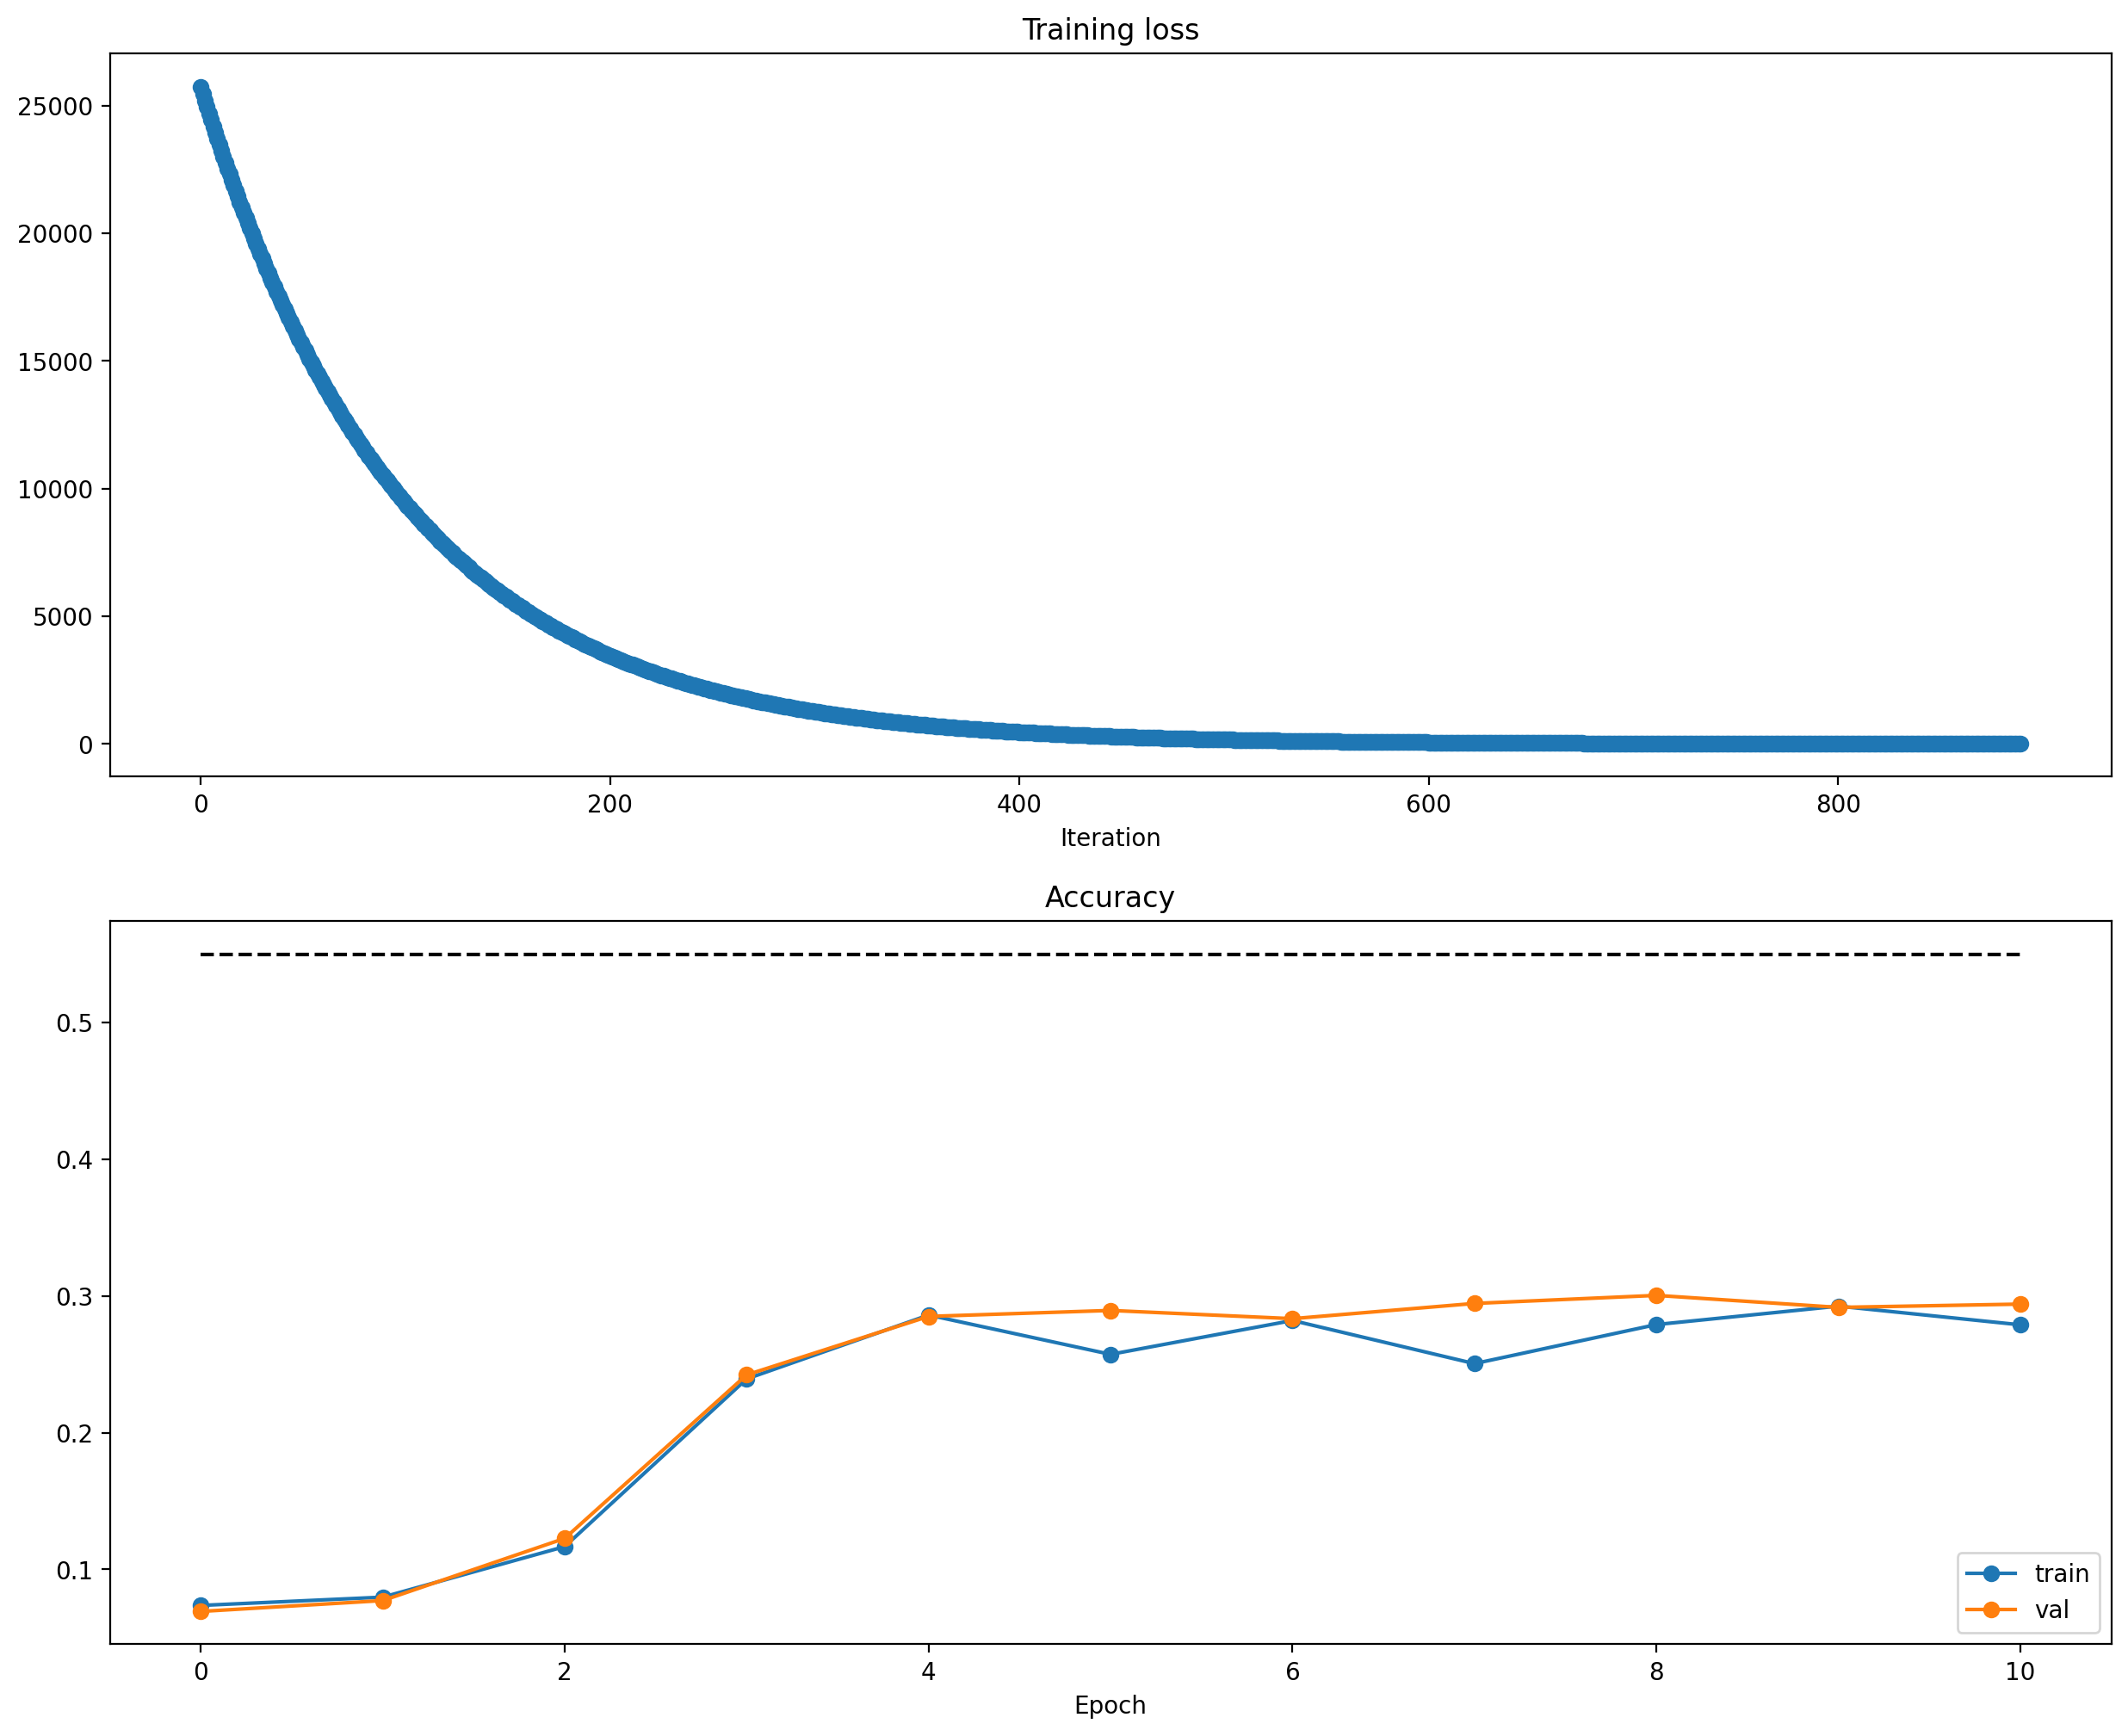

In [22]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.55] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [24]:
#test learning rate
train_accs = []
val_accs = []
lrs = [0.1,0.01,0.001,0.0001]
for mylr in lrs:
    model = TwoLayerNet(input_dim=32*32, hidden_dim=100, num_classes=10, reg=0.5)
    solver = Solver(model, X_train, X_test, y_train, y_test, optim_config = {"learning_rate": mylr})
    solver.train()
    train_acc = solver.check_accuracy(X_train, y_train)
    train_accs.append(train_acc)
    val_acc = solver.check_accuracy(X_test, y_test)
    val_accs.append(val_acc)
for i in range(4):
    print("learning rate {}, train_acc = {:.2%}， val_acc = {:.2%}".format(lrs[i], train_accs[i], val_accs[i]))

(Iteration 1 / 890) loss: 26259.631438
(Epoch 0 / 10) train acc: 0.290604; val_acc: 0.316416
(Iteration 11 / 890) loss: 9392.640813
(Iteration 21 / 890) loss: 3368.605271
(Iteration 31 / 890) loss: 1209.074952
(Iteration 41 / 890) loss: 434.913212
(Iteration 51 / 890) loss: 157.387405
(Iteration 61 / 890) loss: 57.898310
(Iteration 71 / 890) loss: 22.232870
(Iteration 81 / 890) loss: 9.447312
(Epoch 1 / 10) train acc: 0.074000; val_acc: 0.063155
(Iteration 91 / 890) loss: 4.863869
(Iteration 101 / 890) loss: 3.220769
(Iteration 111 / 890) loss: 2.631741
(Iteration 121 / 890) loss: 2.420583
(Iteration 131 / 890) loss: 2.344886
(Iteration 141 / 890) loss: 2.317749
(Iteration 151 / 890) loss: 2.308021
(Iteration 161 / 890) loss: 2.304534
(Iteration 171 / 890) loss: 2.303284
(Epoch 2 / 10) train acc: 0.074000; val_acc: 0.063155
(Iteration 181 / 890) loss: 2.302836
(Iteration 191 / 890) loss: 2.302675
(Iteration 201 / 890) loss: 2.302617
(Iteration 211 / 890) loss: 2.302597
(Iteration 221 /

(Iteration 51 / 890) loss: 24592.296987
(Iteration 61 / 890) loss: 24341.331356
(Iteration 71 / 890) loss: 24090.625311
(Iteration 81 / 890) loss: 23847.812221
(Epoch 1 / 10) train acc: 0.098463; val_acc: 0.092182
(Iteration 91 / 890) loss: 23608.627671
(Iteration 101 / 890) loss: 23374.032080
(Iteration 111 / 890) loss: 23138.827862
(Iteration 121 / 890) loss: 22906.983548
(Iteration 131 / 890) loss: 22677.467462
(Iteration 141 / 890) loss: 22453.746033
(Iteration 151 / 890) loss: 22228.885746
(Iteration 161 / 890) loss: 22007.102684
(Iteration 171 / 890) loss: 21789.159071
(Epoch 2 / 10) train acc: 0.084378; val_acc: 0.071961
(Iteration 181 / 890) loss: 21571.592913
(Iteration 191 / 890) loss: 21357.992798
(Iteration 201 / 890) loss: 21143.535566
(Iteration 211 / 890) loss: 20933.090830
(Iteration 221 / 890) loss: 20724.423590
(Iteration 231 / 890) loss: 20518.357972
(Iteration 241 / 890) loss: 20313.686335
(Iteration 251 / 890) loss: 20112.110950
(Iteration 261 / 890) loss: 19911.85

learning rate 0.1, train_acc = 30.50%， val_acc = 31.64%
learning rate 0.01, train_acc = 29.85%， val_acc = 30.91%
learning rate 0.001, train_acc = 10.38%， val_acc = 10.16%
learning rate 0.0001, train_acc = 28.32%， val_acc = 29.25%


In [25]:
#test hidden size
train_accs = []
val_accs = []
hid = [50,75,100,125]
for h in hid:
    model = TwoLayerNet(input_dim=32*32, hidden_dim=h, num_classes=10, reg=0.5)
    solver = Solver(model, X_train, X_test, y_train, y_test)
    solver.train()
    train_acc = solver.check_accuracy(X_train, y_train)
    train_accs.append(train_acc)
    val_acc = solver.check_accuracy(X_test, y_test)
    val_accs.append(val_acc)
for i in range(4):
    print("hidden size {}, train_acc = {:.2%}， val_acc = {:.2%}".format(hid[i], train_accs[i], val_accs[i]))

(Iteration 1 / 890) loss: 13030.282766
(Epoch 0 / 10) train acc: 0.074015; val_acc: 0.071027
(Iteration 11 / 890) loss: 11708.280818
(Iteration 21 / 890) loss: 10589.130649
(Iteration 31 / 890) loss: 9579.792033
(Iteration 41 / 890) loss: 8665.473354
(Iteration 51 / 890) loss: 7839.333663
(Iteration 61 / 890) loss: 7091.547716
(Iteration 71 / 890) loss: 6415.202419
(Iteration 81 / 890) loss: 5803.715393
(Epoch 1 / 10) train acc: 0.058149; val_acc: 0.063533
(Iteration 91 / 890) loss: 5250.169239
(Iteration 101 / 890) loss: 4749.516795
(Iteration 111 / 890) loss: 4296.718227
(Iteration 121 / 890) loss: 3887.115770
(Iteration 131 / 890) loss: 3516.504874
(Iteration 141 / 890) loss: 3181.256230
(Iteration 151 / 890) loss: 2878.021780
(Iteration 161 / 890) loss: 2603.720806
(Iteration 171 / 890) loss: 2355.549363
(Epoch 2 / 10) train acc: 0.082977; val_acc: 0.063607
(Iteration 181 / 890) loss: 2131.064221
(Iteration 191 / 890) loss: 1928.026473
(Iteration 201 / 890) loss: 1744.321763
(Itera

(Iteration 41 / 890) loss: 17214.672938
(Iteration 51 / 890) loss: 15572.939715
(Iteration 61 / 890) loss: 14087.461028
(Iteration 71 / 890) loss: 12743.922079
(Iteration 81 / 890) loss: 11528.804295
(Epoch 1 / 10) train acc: 0.074162; val_acc: 0.064761
(Iteration 91 / 890) loss: 10429.030221
(Iteration 101 / 890) loss: 9434.363812
(Iteration 111 / 890) loss: 8534.683238
(Iteration 121 / 890) loss: 7720.724503
(Iteration 131 / 890) loss: 6984.450705
(Iteration 141 / 890) loss: 6318.450092
(Iteration 151 / 890) loss: 5715.904244
(Iteration 161 / 890) loss: 5170.985937
(Iteration 171 / 890) loss: 4677.873181
(Epoch 2 / 10) train acc: 0.069673; val_acc: 0.064282
(Iteration 181 / 890) loss: 4231.887264
(Iteration 191 / 890) loss: 3828.417351
(Iteration 201 / 890) loss: 3463.444855
(Iteration 211 / 890) loss: 3133.287499
(Iteration 221 / 890) loss: 2834.620362
(Iteration 231 / 890) loss: 2564.446877
(Iteration 241 / 890) loss: 2320.040331
(Iteration 251 / 890) loss: 2098.956385
(Iteration 2

In [26]:
#test regularization
train_accs = []
val_accs = []
regs = [0.0,0.5,1.0,2.0]
for r in regs:
    model = TwoLayerNet(input_dim=32*32, hidden_dim=100, num_classes=10, reg=r)
    solver = Solver(model, X_train, X_test, y_train, y_test)
    solver.train()
    train_acc = solver.check_accuracy(X_train, y_train)
    train_accs.append(train_acc)
    val_acc = solver.check_accuracy(X_test, y_test)
    val_accs.append(val_acc)
for i in range(4):
    print("regularization {}, train_acc = {:.2%}， val_acc = {:.2%}".format(regs[i], train_accs[i], val_accs[i]))

(Iteration 1 / 890) loss: 96.292693
(Epoch 0 / 10) train acc: 0.236938; val_acc: 0.246281
(Iteration 11 / 890) loss: 40.085092
(Iteration 21 / 890) loss: 27.957718
(Iteration 31 / 890) loss: 30.107597
(Iteration 41 / 890) loss: 27.251554
(Iteration 51 / 890) loss: 21.334029
(Iteration 61 / 890) loss: 9.471293
(Iteration 71 / 890) loss: 4.825298
(Iteration 81 / 890) loss: 3.054723
(Epoch 1 / 10) train acc: 0.090230; val_acc: 0.091242
(Iteration 91 / 890) loss: 2.537328
(Iteration 101 / 890) loss: 2.642496
(Iteration 111 / 890) loss: 3.829817
(Iteration 121 / 890) loss: 2.936030
(Iteration 131 / 890) loss: 2.137516
(Iteration 141 / 890) loss: 2.463016
(Iteration 151 / 890) loss: 2.780749
(Iteration 161 / 890) loss: 2.561216
(Iteration 171 / 890) loss: 2.346957
(Epoch 2 / 10) train acc: 0.075607; val_acc: 0.070587
(Iteration 181 / 890) loss: 2.670967
(Iteration 191 / 890) loss: 2.420898
(Iteration 201 / 890) loss: 2.267122
(Iteration 211 / 890) loss: 2.908301
(Iteration 221 / 890) loss: 2

(Epoch 1 / 10) train acc: 0.067337; val_acc: 0.065952
(Iteration 91 / 890) loss: 8481.546415
(Iteration 101 / 890) loss: 6937.540128
(Iteration 111 / 890) loss: 5674.681438
(Iteration 121 / 890) loss: 4641.771434
(Iteration 131 / 890) loss: 3796.937855
(Iteration 141 / 890) loss: 3105.977167
(Iteration 151 / 890) loss: 2540.827444
(Iteration 161 / 890) loss: 2078.561019
(Iteration 171 / 890) loss: 1700.493002
(Epoch 2 / 10) train acc: 0.171338; val_acc: 0.179929
(Iteration 181 / 890) loss: 1391.213536
(Iteration 191 / 890) loss: 1138.239440
(Iteration 201 / 890) loss: 931.314321
(Iteration 211 / 890) loss: 762.154404
(Iteration 221 / 890) loss: 623.801618
(Iteration 231 / 890) loss: 510.686318
(Iteration 241 / 890) loss: 418.049609
(Iteration 251 / 890) loss: 342.269780
(Iteration 261 / 890) loss: 280.406450
(Epoch 3 / 10) train acc: 0.304000; val_acc: 0.317019
(Iteration 271 / 890) loss: 229.717386
(Iteration 281 / 890) loss: 188.324979
(Iteration 291 / 890) loss: 154.441769
(Iteratio